# Proposal: Early Seeding of COVID-19 via Air Travel: A Europe-Centric

Network Model and Exploratory Correlation with Excess Mortality

Maximilian Elixhauser (University of Salzburg)  
March 27, 2025

## Introduction

In January 2020, a single infected traveler on a long-haul flight could spark an outbreak thousands of kilometers away—turning global aviation into a high-speed conveyor belt for COVID-19. Early analyses demonstrated that aviation can drastically reduce effective distances between cities, accelerating worldwide transmission \[@chinazzi2020; @sun2022_a\]. At the same time, countries exhibited substantial variation in excess mortality, often shaped by demographic factors (e.g., population age, life expectancy) and economic variables (e.g., GDP, healthcare capacity). For example, @rahmanian2024 clustered 21 countries based on excess mortality trajectories and identified government effectiveness, vaccination coverage, and population age structure as key determinants of pandemic-related death rates. Similarly, @matveeva2023 observed that among European countries, lower GDP per capita and slower vaccination rates were associated with higher excess mortality—highlighting the compounding effect of economic capacity and healthcare infrastructure in reducing COVID-19–related deaths.

A less investigated aspect, however, is **epidemic arrival time**: Did countries “hit first” by the virus—when non-pharmaceutical interventions (NPI) were still immature—face worse overall mortality outcomes? This project aims to explore how early seeding of COVID-19 might have compounded the effects of the aforementioned demographic and economic predictors, ultimately shaping the global variability in excess mortality.

As outlined in the Z_GIS Thesis Blog by @neuwirth2024, the **hypothesis** states that **locations hit early and unprepared** faced more severe outbreaks, characterized by:

-   **Longer durations** without access to vaccination  
-   **Lack of effective non-pharmaceutical interventions (NPIs)** during early waves  
-   **Additional outbreak risks** (e.g., secondary winter waves before vaccination was available)

Accordingly, **early epidemic arrival** is expected to correlate with **higher prevalence, reproduction rates, and excess mortality** at the national level.

To test this hypothesis, the initial approach suggested by @neuwirth2024 (which I will evaluate and refine in subsequent sections) followed five key steps:

1.  **Construct a Global Mobility Network (GMN)** using worldwide air travel data from early 2020 (**OpenSky COVID-19 Flight Dataset and/or FlightRadar24 API**) to reproduce the global mobility conditions at the time of the outbreak’s onset (early 2020).
2.  **Implement a SIR network simulation model** as presented by @brockmann2013.  
3.  **Run outbreak simulations** (seeding in Wuhan) to estimate **arrival times (ranks)** of the epidemic in different regions.  
4.  **Validate the model** by comparing simulated epidemic arrivals with reported data.
5.  **Correlate modeled epidemic arrivals with reported excess mortality**, assessing the impact of arrival timing on overall mortality outcomes.

*However, initial evaluation of data sources reveals several practical and methodological challenges, potentially limiting the feasibility of a fully global analysis. I will address these issues and propose methodological refinements in subsequent sections. Finally, I present [my own refined hypothesis and modeling plan.](#hypo)*

## Data Feasibility and Coverage

This section outlines my evaluation of publicly accessible aviation data sources, to assess whether implementing a global SIR model based on air travel data is realistically achievable within the scope of a bachelor’s thesis. The findings justify a Europe-focused network as the most feasible and methodologically sound approach.

Although the initial approach proposed by @neuwirth2024 emphasizes a global-scale simulation using OpenSky or FlightRadar24, preliminary explorations and data evaluations have revealed substantial feasibility challenges. This section addresses key limitations encountered, particularly regarding **data accessibility, coverage issues**, and **practical modeling constraints**.

Specifically, crowdsourced ADS-B datasets such as OpenSky present **significant coverage gaps** in critical regions like China, especially during the early months of the pandemic (e.g., February 2020). Conversely, high-quality commercial datasets such as Eurocontrol, while robust, provide only **limited temporal coverage** (four discrete months per year), complicating continuous epidemic modeling.

### February 2020 Flight Data

During February 2020, the raw OpenSky dataset contained **2,648,835 flight records** (@fig-plot1, top panel). After discarding incomplete entries—flights lacking either an origin or a destination—**1,617,962 records** remained, reflecting a data reduction of **38.92%** (@fig-plot1, bottom panel). Among these cleaned entries, **674 flights** originated in **Mainland China, Hong Kong, or Macau** and terminated within the [Eurocontrol zone’s member states](https://www.eurocontrol.int/our-member-and-comprehensive-agreement-states) (excluding Iceland, which joined in 2025). This modest number illustrates the **limited direct connectivity** captured by OpenSky during this critical month. While likely an **underestimate** of actual passenger flows due to regional coverage gaps, this subset nonetheless provides a valuable **baseline** for modeling early epidemic arrival into Europe.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Rows: 2648835 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): callsign, number, icao24, registration, typecode, origin, destination
dbl  (6): latitude_1, longitude_1, altitude_1, latitude_2, longitude_2, alti...
dttm (3): firstseen, lastseen, day

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 82729 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (15): ident, type, name, continent, iso_country, iso_region, municipalit...
dbl  (4): id, latitude_deg, longitude_deg, elevation_ft

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
summary_data <- data.frame(
  Metric = c(
    "Total flights (raw)", 
    "Total flights (cleaned)", 
    "Percentage removed", 
    "China → Eurocontrol flights"
  ),
  Value = c(
    total_flights, 
    cleaned_flights, 
    paste0(removed_pct, "%"), 
    china_to_europe_flights
  )
)

knitr::kable(summary_data, caption = "Summary of flight data for February 2020.")

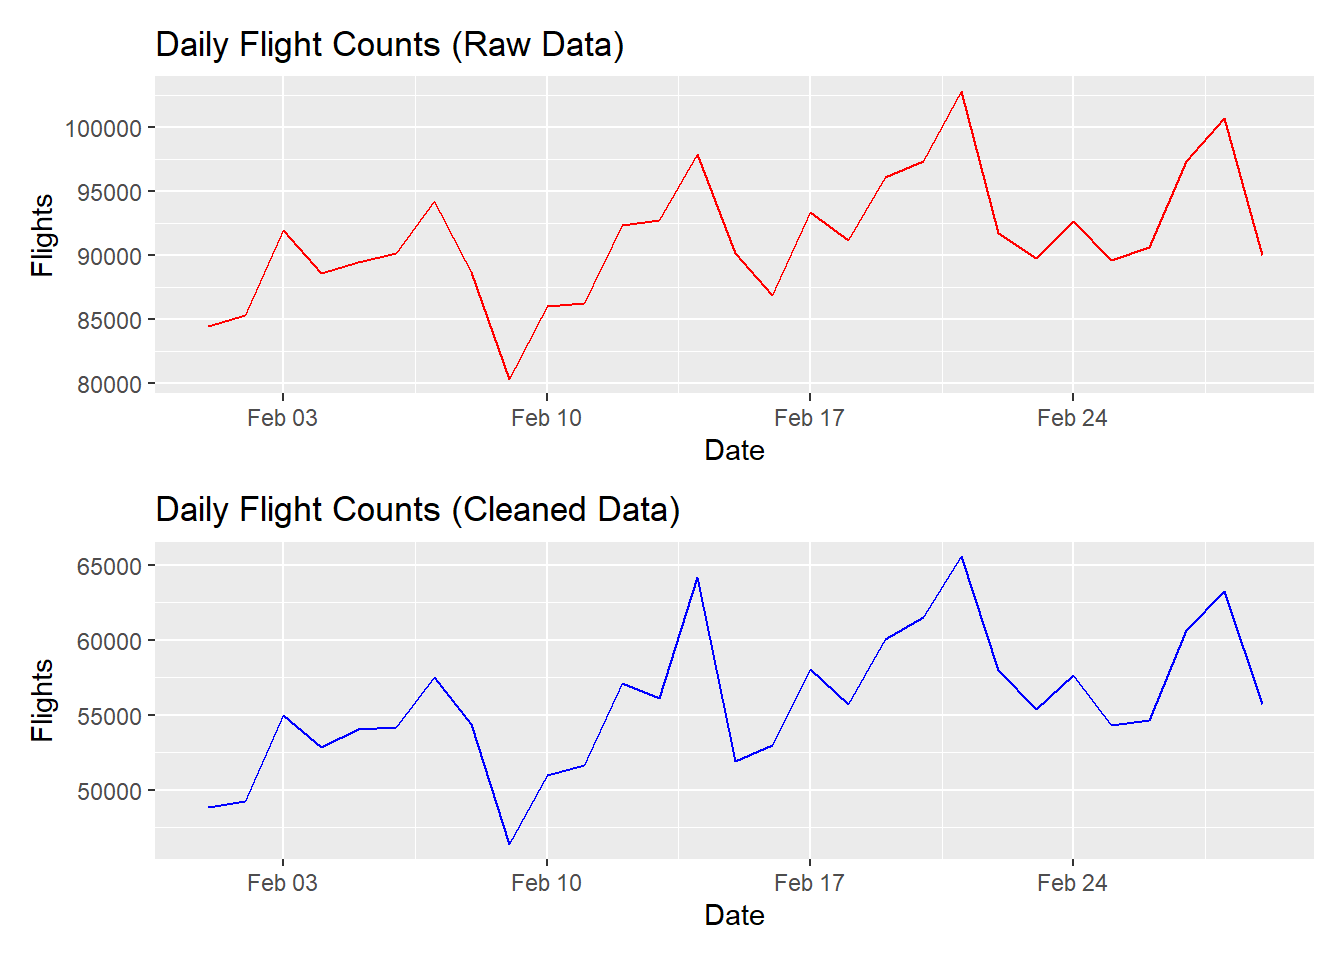

In [ ]:
p_raw <- ggplot(raw_counts, aes(x = day, y = n)) +
  geom_line(color = "red") +
  labs(title = "Daily Flight Counts (Raw Data)", x = "Date", y = "Flights")

p_cleaned <- ggplot(cleaned_counts, aes(x = day, y = n)) +
  geom_line(color = "blue") +
  labs(title = "Daily Flight Counts (Cleaned Data)", x = "Date", y = "Flights")

print(p_raw / p_cleaned)

Given these challenges, a pragmatic adjustment to the original modeling framework is necessary. To overcome these limitations, I propose integrating **multiple complementary data sources**. Specifically, the **OpenSky** dataset from February 2020—despite its limited volume—will serve as a **baseline** for the early epidemic arrival phase. **Eurocontrol** data (starting March 2020), offering comprehensive European flight records, will help validate February’s flight numbers and fill key gaps. For months lacking explicit records, **linear interpolation** and **seasonal normalization** methods may be employed, ensuring continuity in flight data for the initial seeding period. Recognizing early travel restrictions in China (e.g., Wuhan’s lockdown—see [here](#wavetime)) further highlights the importance of including multiple major Chinese airports, rather than focusing on Wuhan alone.

### Crowdsourced ADS-B: Strengths and Weaknesses

Multiple studies have leveraged crowdsourced ADS-B data for COVID-19 mobility analyses \[@suzumura2020; @iacus2020; @salgas2024\], yet coverage remains heavily biased toward North America and Europe. For instance, @suzumura2020 analyzed ~1.9 million flights (1 January–30 April 2020) from OpenSky’s dataset but noted minimal representation of flights into or out of China. By contrast, @strohmeier2021 reports that OpenSky recorded 30,989,481 flights in 2019—roughly 45% of all global flights that year—still undercounting major regions such as China, Africa, and parts of Asia. Consequently, reconstructing Wuhan-based travel for early 2020 remains particularly challenging:

> “OpenSky Network \[…\] does not provide global coverage and \[…\] flight data for major global airports such as the Beijing Capital International Airport in China and the Soekarno-Hatta International Airport in Indonesia are not available.” \[@iacus2020\]

Such large discrepancies between partial flight samples from @suzumura2020 (early 2020 subset) and near-full annual coverage by @strohmeier2021 (2019 totals) underscore the network’s highly uneven global sensor distribution. While some countries enjoy excellent receiver density, enabling robust analysis, large swaths of Asia and Africa have insufficient coverage. This unevenness must be accounted for in any study that relies on ADS-B data for measuring pandemic-related changes in global air travel. Alternatives mentioned below may help to mitigate these gaps, either by incorporating proprietary datasets (OAG/IATA), leveraging regional traffic records, or exploring hybrid machine-learning approaches using open data.

*Given these coverage biases, researchers often look beyond crowdsourced ADS-B to fill critical data gaps, as discussed next.*

### Proprietary Data and Regional Sources

Given the substantial coverage gaps associated with open ADS-B sources, especially concerning early 2020 flights originating in China, researchers often turn to proprietary or regional data providers as more comprehensive alternatives. For instance, the **FlightRadar24 (FR24)** platform, highlighted by @neuwirth2024, offers extensive aviation data through a commercial ADS-B and multilateration network. @quadros2022 successfully utilized FR24 data to compile global civil aviation emissions between 2017 and 2020, demonstrating the potential for capturing diverse flight types—including cargo and unscheduled flights—that traditional schedule-only databases (such as OAG) might omit.

However, FR24 data are also subject to notable constraints:

-   Coverage remains uneven, particularly for periods prior to 2020 and in regions such as Asia and Africa \[@quadros2022\].
-   Data retrieval involves significant computational overhead, as large-scale queries for historical flight positions require substantial processing resources.
-   Cost constraints pose a major barrier. FR24 employs a subscription-based, credit-driven pricing structure:
    -   **Essential tier:** \$90/month, offering 333,000 monthly credits and 2-year historical access.
    -   **Advanced tier:** \$900/month, providing 4,050,000 credits and unlimited historical access (subject to system limitations).

While comprehensive commercial databases (e.g., OAG or IATA) are available and offer near-complete coverage of scheduled flights and passenger flows, they are similarly subscription-based and costly, limiting accessibility primarily to well-funded research projects \[@chinazzi2020\]. As a result, many researchers adopt a regional approach, using datasets like **Eurocontrol** (Europe) or **FAA** (U.S.).

Considering these factors, a preliminary exploration of both Eurocontrol and OpenSky datasets was conducted. While OpenSky data from February 2020 included only **674 China-to-Europe flights, as previously stated.**, Eurocontrol’s data, although comprehensive for specific months (e.g., March, June, August, December), lacked crucial coverage for February 2020—the critical early period of COVID-19’s initial spread to Europe (first detected in France). To address these limitations, a hybrid data integration approach—combining Eurocontrol’s monthly snapshots with OpenSky’s February data—was assessed. This approach would necessitate interpolation of missing monthly flight counts and normalization across datasets, ensuring temporal continuity and data consistency for modeling.

Given the resource-intensity, uneven coverage, and potential analytical limitations posed by global proprietary data, this thesis will adopt a Europe-focused regional approach. By leveraging Eurocontrol’s detailed datasets, supplemented and temporally harmonized with OpenSky data for missing intervals (e.g., February 2020), the analysis will achieve sufficient spatial-temporal granularity to robustly model the early epidemic spread into Europe. This enables focused modeling of the epidemic’s early arrival phase with realistic data quality and processing demands

### ADS-B Exchange Archives

**ADS-B Exchange** offers **high-resolution (5-second interval)** global flight data from **March 2020 onward**. Although this represents an improvement over other open sources, critical coverage gaps persist, especially for **mainland China and specifically Wuhan**, significantly limiting its usefulness for capturing the pandemic’s initial spread phase \[@salgas2024\]. Since the primary research question of this thesis concerns the early months of 2020 (January and February), ADS-B Exchange cannot adequately fill these crucial temporal gaps.

*Thus, despite its detailed nature, the post-March 2020 coverage of ADS-B Exchange is insufficient to study the earliest phases of COVID-19 transmission relevant to this research.*

### A Different Approach: Wikipedia + XGBoost

A promising open-data alternative to overcome gaps in aviation datasets has been recently proposed by @salgas2024. Their method merges **Wikipedia-scraped airport route data** with **XGBoost-based seat-capacity estimations**, providing a novel way to impute missing flight connections. Although originally applied to **2019 data**, this approach theoretically could be extended to early 2020 using historical Wikipedia snapshots (e.g., via the Internet Archive).

However, as emphasized by @salgas2024, this method requires substantial effort, including:

-   manual Wikipedia data extraction,
-   significant data cleaning,
-   iterative training and validation of the machine learning model, and
-   careful integration with radar-based or administrative flight records.

These processes are described as **“long and complex”** and yield results primarily suitable for **aggregated analyses at national or continental levels**, rather than precise route-level accuracy. Given the practical scope and limited available hours (~300 hours) for this bachelor’s thesis, adopting this full-scale Wikipedia + XGBoost pipeline would exceed project constraints. Therefore, while innovative and valuable for future research endeavors requiring comprehensive global data, this approach is considered beyond the feasible scope of the current thesis.

*Thus, despite its methodological innovation, the Wikipedia + XGBoost strategy is judged impractical for this project’s timeframe and resource constraints.*

### Seats vs. Actual Passengers

Another notable methodological challenge arises from the discrepancy between available data (typically seat capacities) and actual passenger numbers. Most **open-source flight datasets** (e.g., OpenSky, ADS-B Exchange) lack explicit passenger information, leading researchers to estimate traveler numbers by applying **assumed passenger load factors (PLF)** to seat capacities.

Pre-pandemic, the global PLF reached a record **82.6% in 2019** \[@IATA2020\], yet dropped sharply to **65.2% in 2020** due to COVID-19 \[@Statista2024\]. This rapid decline introduced additional uncertainty into passenger-flow estimates. However, relying on seat capacity data introduces several compounding inaccuracies in estimating actual passenger flows:

-   **Cargo flights misidentified as passenger flights**: Unlabeled cargo-only operations may mistakenly inflate passenger estimates if treated as passenger flights \[@suzumura2020\].
-   **Reduced occupancy and ghost flights**: Many flights operated near-empty to maintain airport slots or for regulatory purposes \[@sun2022_b\], complicating the reliability of simple PLF approximations.

*Given the data availability constraints, the common practice of multiplying seat capacities by historical or assumed PLFs remains necessary, despite acknowledging these inherent limitations. This thesis explicitly recognizes potential inaccuracies and will incorporate sensitivity analyses on these load-factor assumptions where feasible.*

### Are Passengers “Isolated” in Transit? How Does This Affect the Model?

A further simplification inherent to large-scale network models, such as the **SIR** model presented by @brockmann2013, involves treating air travel as instantaneous transmission events:

-   **No in-flight quarantine or detailed cabin modeling**: Passengers are not considered isolated during flights; the model effectively assumes immediate infection potential upon arrival.
-   **Ignored intra-cabin transmission**: While cabin-specific airflow and seating arrangements can influence in-flight transmission \[@wang2023\], these micro-level factors are typically omitted in macro-scale epidemic models due to computational and data complexity.

Thus, flights function primarily as **network links facilitating long-distance virus introductions**, rather than detailed sites of infection dynamics.

**In conclusion**, given the significant limitations of global datasets, the initial modeling concept is pragmatically refined into a regional, Europe-centric approach. By leveraging Eurocontrol’s robust flight data, supplemented with OpenSky coverage for missing intervals (e.g., February 2020), the thesis ensures a realistic and feasible foundation for simulating early epidemic arrival.

The following section discusses the rationale and implications of this regional scope, before outlining the modeling strategy and practical implementation steps using a network-based SIR framework

## Rationale and Potential Approaches for Future Research

### Regional vs. Global Scope

Given the substantial limitations of available aviation data, a key methodological decision concerns the appropriate geographic scope for epidemic modeling. A **global approach**, while conceptually appealing for its comprehensiveness, encounters major data challenges—particularly in regions with sparse ADS-B coverage, such as China, Southeast Asia, and Africa \[@suzumura2020; @iacus2020\]. To bridge these gaps, researchers have proposed techniques like Wikipedia scraping combined with XGBoost-based seat-capacity estimation \[@salgas2024\]. However, as previously noted, these methods demand extensive manual effort and model calibration, making them impractical within the timeframe of a bachelor’s thesis.

By contrast, a **regional scope**, focused on **Europe**, offers several clear advantages:

-   **Reliable data availability**, especially through the Eurocontrol network, which provides consistent and detailed flight records across European airspace.
-   **Greater methodological robustness**, due to high-quality coverage from both Eurocontrol and complementary sources like OpenSky.
-   **Feasibility**, aligning with the time and resource constraints of this thesis (~300 hours), while still supporting a well-founded and analytically meaningful approach.

Additionally, **domestic and intra-country mobility patterns** have been shown to play a critical role in COVID-19 spread. For example, @laroze2021 demonstrated that commuting flows significantly influenced case dynamics across English districts. A Europe-centric modeling strategy thus not only accommodates data feasibility, but also allows for more realistic representation of both international and subnational transmission pathways—without the burden of full-scale global modeling.

**Given these considerations**, this thesis adopts a Europe-focused network approach, enabling the investigation of epidemic seeding patterns and their potential association with first-wave excess mortality across European countries.  
The next section outlines the methodological steps taken to operationalize this framework using a network-based epidemic model.

### SIR as a Model Implementation

This thesis employs a **network-based SIR model**, as originally presented by @brockmann2013, to simulate the initial spread of COVID-19 through the European aviation network. Although **Wuhan** would ideally serve as the starting node (initial seeding), early 2020 data limitations necessitate the inclusion of additional major Chinese airports (e.g., **Shanghai, Beijing, Shenzhen**) as proxies—particularly given Wuhan’s strict lockdown beginning on **23 January 2020** \[@chinazzi2020\]. This adjustment aligns with findings from previous studies that emphasize the role of multiple international hubs in the early global dissemination of the virus \[@lai2020\].

Wuhan is widely acknowledged as a critical internal transport nexus \[@zhang2020_a; @zhu2019\], with air passenger flows strongly correlated to outbreak severity in downstream regions \[@zhao2020; @ai2020\]. However, since **rail, road, and air** all contributed to the virus’s domestic spread, focusing solely on Wuhan airport risks underestimating exportations—especially after the lockdown. Incorporating other large airports thus provides a more comprehensive approximation of early seeding routes into Europe.

A more complex modeling alternative would be a compartmental **SEIR** model—or its multi-stage variant, **SEnIR**—which incorporates a more realistic, Gamma-distributed incubation period and typically yields enhanced epidemiological fidelity \[@abou2020; @rozan2024\]. These models provide richer insights into epidemic peaks, spread dynamics, and intervention effects. However, they demand more parameters, careful calibration, and significant computational resources, often necessitating agent-based or fine-grained simulations.

*Given the resource constraints of this thesis, the simplified **SIR model**—with a mean-rate approximation of incubation and recovery periods, as proposed by @brockmann2013 is considered sufficient to estimate the **relative timing of epidemic arrival** across European countries. Future extensions may explore more detailed models (e.g., SEnIR) to examine secondary waves, intervention effects, or longer-term dynamics in greater depth.*

## Specified Data

Many flight movement data providers (e.g., FR24, OpenSky, ADS-B Exchange) rely heavily on **crowdsourced ADS-B** signals. While these datasets offer broad accessibility, they often suffer from **uneven geographic coverage**, particularly in regions with sparse ADS-B receiver infrastructure, introducing potential biases.

In contrast, **Eurocontrol** compiles data from **flight plans and radar-based updates** for all **IFR (Instrument Flight Rules)** flights across European airspace. By aggregating inputs from various **Air Navigation Service Providers (ANSPs)**, Eurocontrol offers a centralized, **operationally verified** dataset with high reliability—making it a cornerstone of this thesis’s regional modeling approach.

### Access & Terms of Service

-   Eurocontrol data is made available through a dedicated **R&D platform** strictly for **non-commercial research purposes**.
-   Access requires **user registration** and agreement to the Terms of Service (TOS).
-   Although **raw flight-level ATM data** cannot be published, **aggregated or derived insights** (e.g., maps, visualizations) may be shared publicly, provided **Eurocontrol is properly credited**.
-   For this thesis, I obtained **personal access** under these conditions and remain in full compliance with the data-sharing agreement.

### Airport Reference Data

To link flight records to physical airport locations and relevant metadata (ICAO/IATA codes, coordinates, airport type), this thesis uses the openly available dataset provided by [**OurAirports**](https://ourairports.com/). This dataset includes global coverage of airports, heliports, and similar facilities and is updated daily. The version used here (`airports.csv`, dated 24 March 2025) was obtained directly from the [OurAirports Data Portal](https://ourairports.com/data/).

### Data Availability & Format

-   Eurocontrol datasets are available for **four months per year**: March, June, September, and December.
-   They include **commercial flights only**, categorized as either scheduled (`S`) or non-scheduled (`N`) operations. General aviation and military flights are excluded.
-   Each record contains detailed flight attributes: scheduled/actual departure and arrival times, aircraft types (ICAO 8643), airline/operator (ICAO 8585), route waypoints, and flight route metadata updated per **AIRAC cycle**.
-   Given the **temporal discontinuity** (four-month snapshots), **supplementary sources** such as OpenSky are used to provide continuity between these periods.

> **Data Handling:** For further information on licensing and sharing constraints, see the [EUROCONTROL ATM R&D Datasets – Terms of Use](https://www.eurocontrol.int/publication/eurocontrol-atm-rd-datasets-terms-use). This thesis adheres strictly to the non-commercial use terms, with no raw data publication.

### Combining with OpenSky

To address gaps between Eurocontrol’s quarterly snapshots, this thesis integrates data from the **OpenSky Network** \[@olive2023\]. Despite limitations—particularly in regions such as **China and Africa**—OpenSky provides **continuous monthly flight data**, making it an ideal supplement for capturing evolving traffic trends, especially during the early seeding phase of COVID-19 in **January–February 2020**. By aligning and interpolating data between OpenSky and Eurocontrol, a coherent and temporally complete picture of early epidemic-related mobility patterns in Europe is achieved.

### Modeling Europe’s Initial COVID-19 Wave and Time Windows

Although **officially recognized** European COVID-19 cases did not appear until January 2020, at least one retrospective study suggests that SARS-CoV-2 may have reached Europe as early as **late December 2019** \[@deslandes2020\]. That study identified a positive SARS-CoV-2 test in a stored respiratory sample from a patient in the Paris region—providing *circumstantial evidence* of earlier, isolated introductions. However, the authors note this does not confirm widespread circulation at the time.

By most accounts, the **major viral seeding** in Europe occurred via air travel from China during **January and February 2020** \[@chinazzi2020\]. Over this period, travel restrictions were introduced gradually:

-   **23 January 2020:** Wuhan implemented a citywide lockdown. However, international air traffic continued briefly thereafter. As shown by @chinazzi2020, Wuhan’s travel restrictions delayed epidemic progression within China by only 3–5 days, but **reduced international case exportations by nearly 80%** until mid-February.

    -   Modeling further showed that even **90% reductions in travel volume** would only delay—rather than prevent—global spread, unless accompanied by significant local transmission control.

-   **Late January – Early February 2020:** Several countries enacted formal travel bans (e.g., the U.S. on 31 January, Australia on 1 February). Still, indirect travel via international hubs like **Dubai** and **Doha** continued \[@whitehouse2020proclamation; @australia2020ban; @sun2020\], maintaining pathways for virus spread.

-   **March 2020:** Full lockdown measures across Europe severely curtailed mobility—but by this point, **community seeding** had already occurred.

-   **8 April 2020:** After ~10 weeks of domestic lockdown, Wuhan resumed air and train services, highlighting how **aviation networks** can both delay and re-enable global epidemic spread \[@zhang2020_a\].

To capture these dynamics, this thesis integrates:

-   **OpenSky (January–February, April 2020):** Offers continuous coverage of early seeding and post-lockdown trends.
-   **Eurocontrol (March 2020):** Provides high-resolution data during Europe’s most intense restriction phase.

By combining these sources, the model captures the **critical early period of epidemic arrival and restriction** in Europe, even while accepting limited visibility into non-European transit (e.g., via Middle East hubs).

> While airports like Dubai or Doha were important global transfer points in February, this thesis focuses on **direct seeding from China** and **intra-European flows**. Modeling later pandemic phases or full global mobility networks exceeds the practical scope of this project.

### Correlation with Excess Mortality

Following simulation of epidemic arrival timing across Europe using the adjusted SIR model, these predicted **arrival ranks** will be compared with national **excess mortality rates** to explore whether early seeding corresponded with worse mortality outcomes \[@theeconomist2021\].

An upcoming short communication by **Neuwirth & Elixhauser (202x, in prep.)** notes that the **most consistent excess mortality estimates and associated predictors** (GDP, HAQ, vaccination rates) are concentrated in Europe. Although the original modeling concept considered global mortality variation, the **density and reliability** of European data ultimately justify a **Europe-focused analysis**.

> *While including additional socioeconomic controls would deepen the analysis, this lies beyond the scope of this thesis. Nevertheless, the correlation between arrival timing and mortality provides meaningful insight into early pandemic dynamics.*

### Excess Mortality Data

To estimate country-level excess mortality during Europe’s first COVID-19 wave, this thesis uses values published by **The Economist** \[@theeconomist2021\]. Their model estimates **excess deaths** by imputing missing official data using machine learning, as detailed in [their methodological article](https://www.economist.com/graphic-detail/2021/05/13/how-we-estimated-the-true-death-toll-of-the-pandemic).

Although these estimates carry uncertainty—especially for countries with weak death registration systems—they provide one of the **most consistent global sources** of excess mortality. For this thesis, aggregated values from **January to April 2020** are used, focusing on the **first European wave** and avoiding the confounding effects of later interventions, variants, and vaccine rollouts.

## Advanced Research Question & Hypothesis

### Research Question

> Does the timing of epidemic seeding—estimated from integrated air traffic data (OpenSky for January–February and April; Eurocontrol for March 2020)—correlate with higher excess mortality during the first wave of COVID-19 in Europe?

### Hypothesis

This thesis hypothesizes that **countries experiencing earlier epidemic seeding**, as inferred from the integrated flight network analysis (January–April 2020), will exhibit **higher first-wave excess mortality**. While additional socioeconomic controls (e.g., GDP, healthcare access, vaccination rates) would enhance causal inference, this study deliberately focuses on the **direct association** between epidemic arrival timing and mortality outcomes. These factors are acknowledged as important contextual variables but remain outside the immediate analytical scope.

The proposed mechanism underlying this association includes:

-   **Reduced time for intervention**:  
    Early-seeded countries likely had less time to implement effective non-pharmaceutical interventions (NPIs), contributing to faster spread and higher initial case loads.

-   **Increased strain on healthcare systems**:  
    Health infrastructure may have been overwhelmed more quickly in countries where the virus arrived early, exacerbating mortality rates.

-   **Greater exposure via international hubs**:  
    High-traffic airports (e.g., Frankfurt, Paris, London) likely acted as primary entry points, intensifying early epidemic dynamics in densely connected regions.

By integrating OpenSky and Eurocontrol data, the Europe-centric simulation model aims to **reconstruct early seeding patterns** and examine whether they correlate meaningfully with observed cross-national differences in excess mortality.

## Research Design and Methodology

Following the recommendation of my **supervisor (March 14, 2025)**, the analysis deliberately avoids **complex agent-based modeling (ABM)** in favor of a **simplified, yet informative, network-based SIR model** \[@brockmann2013\]. This modeling choice is grounded in:

-   **Feasibility**:  
    Avoids excessive parameter tuning and simulation complexity, aligning with the limited timeline (~300 hours) of a bachelor’s thesis.  
-   **Data compatibility**:  
    Aggregated flight flows between airports can be meaningfully represented as weighted network edges.  
-   **Preservation of key dynamics**:  
    The model captures essential characteristics of epidemic seeding and early spread, sufficient for exploratory correlation with mortality outcomes.

### Specific Methodological Steps

1.  **Construct a European Mobility Network (EMN)**
    -   Select and prioritize European airports based on data completeness (Eurocontrol/OpenSky), focusing on major hubs (e.g., Paris, London, Frankfurt) with high international traffic.  
    -   Estimate **passenger flows** between airports using *seat capacity × assumed load factor (PLF)*.
        -   **Important caveat**: This method may overestimate flows in cases of ghost flights, cargo-only flights, or low occupancy. Therefore, **sensitivity checks** using multiple PLF scenarios (e.g., 50%, 70%, 90%) will assess the robustness of results.  
    -   Create **visualizations** (e.g., Sankey diagrams) at the airport level for descriptive insight. For statistical analyses, flows are **aggregated at the country level**.
2.  **Implement a Simplified ODE-Based SIR Model**
    -   Represent each airport as a node with daily transitions between Susceptible (S), Infected (I), and Recovered (R) compartments.
    -   **Flight-Based Passenger Flows:** Incorporate **direct China-to-Europe flights** (for initial seeding) and **major intra-European routes** (for subsequent spread). Although the raw data may include all commercial flights, **low-volume or purely domestic routes** can be **aggregated** at the country level to avoid excessive model granularity.
    -   Instead of focusing solely on Wuhan, include flights from **multiple** Chinese airports (e.g., **Shanghai, Beijing, Shenzhen**) to better approximate COVID-19 exportation after Wuhan’s 23 January 2020 lockdown \[@chinazzi2020; @zhang2020_a\].
3.  **Estimate Country-Level Epidemic Arrival Times**
    -   Define an **infection threshold** at each airport (e.g., cumulative I surpasses a specific value) to mark seeding.  
    -   Aggregate arrival dates to the **country level**, yielding a timeline of inferred epidemic arrival for each European country.
4.  **Rank Countries by Estimated Epidemic Arrival**
    -   Create a rank-order list of countries based on modeled arrival dates to establish relative positions in the epidemic seeding sequence.
5.  **Correlate with Excess Mortality**
    -   Use **Spearman’s rank correlation** to test the association between a country’s arrival rank and its first-wave excess mortality estimate (January–April 2020).  
    -   Acknowledge that this analysis is **exploratory** and does not include socioeconomic confounders. Its primary aim is to assess the plausibility of **arrival timing as a partial explanatory factor** in mortality variation.

### Project Timeline

> *Work began on March 1, 2025, with a focus on data evaluation, feasibility testing, and early exploratory analysis. The project will be completed by August 20, 2025, with steady progress throughout the upcoming months. The thesis is worth 12 ECTS, corresponding to approximately 300 working hours.*

| Phase | Timeframe | Notes |
|------------------------------------|----------------------------|--------|
| Initial Data Exploration & Scope | Mar 1 – Mar 27 | Completed – assessed OpenSky, Eurocontrol, global feasibility |
| Formal Proposal Writing | Mar 15 – Mar 31 | In progress (this document) |
| Network Construction + SIR Prep | Apr 1 – Apr 30 | Integrate flight datasets, construct network, prepare SIR model |
| Epidemic Simulation & Calibration | May 1 – May 31 | Simulate spread, test scenarios, define arrival thresholds |
| Mortality Correlation Analysis | Jun 1 – Jun 15 | Spearman correlation with excess mortality estimates |
| Writing, Visuals & Revisions | Jun 16 – Aug 10 | Draft thesis, create figures, finalize methods & results |
| Final Review & Submission | Aug 10 – Aug 20 | Final edits, submission to supervisor |

## References